# 強化学習 3日目 @ Summer School 数理物理 2021
## TD learning with eligibility trace
***
Tetsuro Morimura, 2021

### Import required Python packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
### Define Markov Decision Process & Environment

In [3]:
class MDP:
    def __init__(self, state_set, action_set, init_prob, trans_prob, reward_fun):
        self.state_set   = state_set
        self.action_set  = action_set
        self.nstate      = len(state_set)
        self.naction     = len(action_set)
        self._init_prob  = init_prob
        self._trans_prob = trans_prob   #d1:state, d2:action, d3:next_state
        self._reward_fun = reward_fun   #d1:state, d2:action
        self._state      = None
        self._action     = None
        self._reward     = None
    def set_state(self, state):
        self._state  = state
    def set_action(self, action):
        self._action = action
    def get_trans_matrix(self, state):
        return np.array(self._trans_prob[state])
    def get_reward_vec(self, state):
        return np.array(self._reward_fun[state])
    def get_state(self):
        return self._state
    def get_action(self):
        return self._action
    def get_reward(self):
        return self._reward_fun[self._state][self._action]
    def get_value_fun(self, gamma, policy): 
        r_s  = np.zeros(mdp.nstate)
        P_ss = np.zeros(mdp.nstate*mdp.nstate).reshape(mdp.nstate, mdp.nstate)
        if np.shape(policy) == (self.nstate,): # deterministic policy
            for s in range(mdp.nstate):
                r_s[s]  = mdp.get_reward_vec(s) [policy[s]]
                P_ss[s] = mdp.get_trans_matrix(s)[policy[s]]
        else: # stochastic policy
            policy = np.array(policy)
            for s in range(mdp.nstate):
                r_s[s]  = np.inner(policy[s], mdp.get_reward_vec(s))
                P_ss[s] = np.inner(policy[s], mdp.get_trans_matrix(s).T)
        value_fun = np.linalg.solve(np.eye(mdp.nstate)-gamma*P_ss, r_s)  # solve Ax = b 
        return value_fun
    def reset(self):
        init_state  = np.random.choice(self.state_set, p=self._init_prob)
        self._state  = init_state
        self._action = None
        return init_state
    def step(self, action=None):
        state = self.get_state()
        if action is None:
            action = self.get_action()
        else:
            self.set_action(action)
        if state is None or action is None:
            raise Exception("'state' or/and 'action' is not set!")
        next_state   = np.random.choice(self.state_set, p=self._trans_prob[state][action])
        reward       = self.get_reward()
        self._state  = next_state
        self._reward = reward
        self._action = None
        return next_state, reward

class Environment(MDP):
    def set_state(self):
        raise Exception("This method is not available!") # 自由に状態をリセットできないので。
    def get_trans_matrix(self):
        raise Exception("This method is not available!")
    def get_reward_vec(self):
        raise Exception("This method is not available!")

In [4]:
### Generate Environment (env) instance

In [5]:
state_set  = [0,1,2]
action_set = [0,1]
init_prob  = [0.6, 0.3, 0.1]
trans_prob = np.zeros(len(state_set)*len(action_set)*len(state_set)).reshape(len(state_set), len(action_set), len(state_set)) #d1:state, d2:action, d3:next state
trans_prob[0][0] = [1,   0,   0]
trans_prob[0][1] = [0.5, 0.5, 0]
trans_prob[1][0] = [1,   0,   0] 
trans_prob[1][1] = [0,   0.5, 0.5]
trans_prob[2][0] = [0,   1,   0]
trans_prob[2][1] = [1,   0,   0]
reward_fun       = [  [1.0, -1.0],
                      [1.0, -1.0],
                      [1.0, 12.0], ]   #d1:state, d2:action

mdp = MDP(state_set, action_set, init_prob, trans_prob, reward_fun)
env = MDP(state_set, action_set, init_prob, trans_prob, reward_fun)
del state_set, action_set, init_prob, trans_prob, reward_fun

In [6]:
## TD(lambda) learning

In [7]:
gamma  = 0.9         # discounting rate
n_time = 2001
policy = [[.5,.5],   # stochastic policy  
          [.5,.5],
          [.5,.5]]
alp = 0.2            # learning rate
lam = 0.5            # eligibility decay rate
value_fun       = np.zeros(env.nstate)
eligibility     = np.zeros(env.nstate)

# set store variables
value_fun_store = np.tile(value_fun, (n_time,1))

# main
for t in range(n_time):
    # store 
    value_fun_store[t] = value_fun

    # update state
    if t==0:
      state = env.reset()
    else:
      state = next_state

    # transition
    action             = np.random.choice(env.action_set, p=policy[state])
    #rint(env.step(action))
    next_state, reward = env.step(action)

    # update eligibility
    vec              = np.zeros(env.nstate)
    vec[state]       = 1
    eligibility      = lam*gamma*eligibility[state] + vec
    # update value-function
    td_error         = reward + gamma*value_fun[next_state] - value_fun[state]
    for s in env.state_set:
        value_fun[s]   += (1-lam*gamma) * alp * eligibility[s] * td_error

In [8]:
### Visualize results

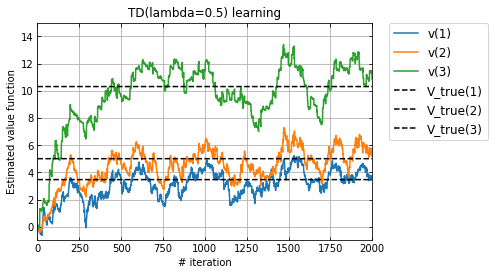

In [9]:
# calc true-value-function
value_fun = mdp.get_value_fun(gamma,policy)

# plot
xs = range(n_time)
plt.plot(xs, value_fun_store)
plt.plot(xs, np.tile(value_fun, (xs[-1]+1,1)), 'k--')
plt.xlabel('# iteration')
plt.ylabel('Estimated value function')
plt.xlim(xs[0],xs[-1])
plt.ylim(-1,15)
plt.tick_params(top = True, right = True, direction = 'in')
plt.legend(['v(1)', 'v(2)','v(3)', 'V_true(1)','V_true(2)','V_true(3)'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.grid(which='both')
plt.title('TD(lambda={}) learning'.format(lam))
plt.show()